In [1]:
#Installing packages and loading them into the enviroment
install.packages("MASS")
library("MASS")
install.packages("missMDA")
library("missMDA")
install.packages("tidyverse")
library("tidyverse")
install.packages("caret")
library("caret")
install.packages("mice")
library("mice")
install.packages("ggrepel")
library("ggrepel")
install.packages("pROC")
library("pROC")

Installing package into 'C:/Users/2198K/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'MASS' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'MASS'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\2198K\Documents\R\win-library\4.0\00LOCK\MASS\libs\x64\MASS.dll to C:\Users\2198K\Documents\R\win-library\4.0\MASS\libs\x64\MASS.dll: Permission denied"
Warning message:
"restored 'MASS'"



The downloaded binary packages are in
	C:\Users\2198K\AppData\Local\Temp\Rtmpa8oNfm\downloaded_packages


Installing package into 'C:/Users/2198K/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'missMDA' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\2198K\AppData\Local\Temp\Rtmpa8oNfm\downloaded_packages


Installing package into 'C:/Users/2198K/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\2198K\AppData\Local\Temp\Rtmpa8oNfm\downloaded_packages


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks MASS::select()

Installing package into 'C:/Users/2198K/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'caret' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'caret'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\2198K\Documents\R\win-library\4.0\00LOCK\caret\libs\x64\caret.dll to C:\Users\2198K\Documents\R\win-library\4.0\caret\libs\x64\caret.dll: Permission denied"
Warning message:
"restored 'caret'"



The downloaded binary packages are in
	C:\Users\2198K\AppData\Local\Temp\Rtmpa8oNfm\downloaded_packages


Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Installing package into 'C:/Users/2198K/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'mice' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'mice'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\2198K\Documents\R\win-library\4.0\00LOCK\mice\libs\x64\mice.dll to C:\Users\2198K\Documents\R\win-library\4.0\mice\libs\x64\mice.dll: Permission denied"
Warning message:
"restored 'mice'"



The downloaded binary packages are in
	C:\Users\2198K\AppData\Local\Temp\Rtmpa8oNfm\downloaded_packages



Attaching package: 'mice'


The following object is masked from 'package:stats':

    filter


The following objects are masked from 'package:base':

    cbind, rbind


Installing package into 'C:/Users/2198K/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'ggrepel' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'ggrepel'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\2198K\Documents\R\win-library\4.0\00LOCK\ggrepel\libs\x64\ggrepel.dll to C:\Users\2198K\Documents\R\win-library\4.0\ggrepel\libs\x64\ggrepel.dll: Permission denied"
Warning message:
"restored 'ggrepel'"



The downloaded binary packages are in
	C:\Users\2198K\AppData\Local\Temp\Rtmpa8oNfm\downloaded_packages


Installing package into 'C:/Users/2198K/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'pROC' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'pROC'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\2198K\Documents\R\win-library\4.0\00LOCK\pROC\libs\x64\pROC.dll to C:\Users\2198K\Documents\R\win-library\4.0\pROC\libs\x64\pROC.dll: Permission denied"
Warning message:
"restored 'pROC'"



The downloaded binary packages are in
	C:\Users\2198K\AppData\Local\Temp\Rtmpa8oNfm\downloaded_packages


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var




In [3]:
#Loading all needed files,dropping first two coloumns, which are not needed for analysis (ID, species)
ionomics <- read.csv('spec_woAestPalm_xyz_concat.csv', colClasses =c("NULL","NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))
hybrids <- read.csv('spec_shoot_xyz_concat_unk_only.csv', colClasses = c("NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,
                                                                    NA,NA,NA,NA,NA,NA,NA))

#Imputation via missMDA
imputeIonomics <- imputePCA(ionomics, method = "Regularized")

In [4]:
#Imputation via Mice
# TODO add in fit graphics and missing data quantification
temp <- mice(ionomics, m = 1, maxit = 5, method = "norm.boot", seed = 567)
ionomicsComplete <- complete(temp,1)


 iter imp variable
  1   1  S34_X
  2   1  S34_X
  3   1  S34_X
  4   1  S34_X
  5   1  S34_X


In [5]:
#data imputed with missMDA regularized method
mean.impute <- 0 #Start our average with 0
auc <- 0
for (x in 1:1000){ # run 1000 permutations
    set.seed(x) #cycle through many random generator seeds
    training.samples.impute <- imputeIonomics$completeObs[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.impute <- imputeIonomics$completeObs[training.samples.impute, ] #generate training set
    test.data.impute <- imputeIonomics$completeObs[-training.samples.impute, ] #generate test set
    train.data.impute <- unlist(train.data.impute) #typecast from matrix into dataframe
    test.data.impute <- unlist(test.data.impute)
    train.data.impute <- as.data.frame(train.data.impute)
    test.data.impute <- as.data.frame(test.data.impute)
    model.impute <- lda(spec_as_int~., data = train.data.impute) #generate the LDA model
    predictions.impute <- model.impute %>% predict(test.data.impute) #predict the species of individuals in our test set based off of this model
    mean.impute = mean.impute + mean(predictions.impute$class==test.data.impute$spec_as_int) #measure how often this prediction is correct, then add it to a running total
    m.roc <- multiclass.roc(test.data.impute$spec_as_int, as.numeric(predictions.impute$class), direction = "<") #measures area under the curve for classifier metric accuracy
    auc <- auc + m.roc$auc
}
mean.impute = mean.impute/999 #divide running total by number of runs to find our average
auc <- auc/999
auc #print the AUC average to the screen
mean.impute #print the LDA model average to the screen

Multi-class area under the curve: 0.8116

[1] 0.785035

In [6]:
#data imputed with mice, norm.boot method
mean.mice = 0 #Start our average with 0
auc = 0
for (x in 1:1000){ #run 10000 permutations
    set.seed(x)  #cycle through many random generator seeds
    training.samples.mice <- ionomicsComplete[,2] %>%
        createDataPartition(p = 0.8, list = FALSE) #split the data into training (80%) and testing (20%)
    train.data.mice <- ionomicsComplete[training.samples.mice, ] #generate training set
    test.data.mice <- ionomicsComplete[-training.samples.mice, ] #generate test set
    model.mice <- lda(spec_as_int~., data = train.data.mice) #generate the LDA model
    predictions.mice <- model.mice %>% predict(test.data.mice) #predict the species of individuals in our test set based off of this model
    mean.mice = mean.mice + mean(predictions.mice$class==test.data.mice$spec_as_int) #measure how often this prediction is correct, then add it to a running total
    m.roc <- multiclass.roc(test.data.mice$spec_as_int, as.numeric(predictions.mice$class), direction = "<") #measures area under the curve for classifier metric accuracy
    auc <- auc + m.roc$auc
}
mean.mice = mean.mice/999 #divide running total by number of runs to find our average LDA model accuracy
auc <- auc/999 #divide running total by number of runs to find our average AUC accuracy
auc #print the AUC average to the screen
mean.mice #print the LDA model average to the screen

Multi-class area under the curve: 0.8117

[1] 0.7850072

|species|spec_as_int|
|---|---|
|acerifolia_x|1|
|cinerea_x|3|
|labrusca_x|4|
|riparia_x|6|
|rupestris_x|7|
|vulpina_x|8|

In [7]:
df.impute <- as.data.frame(unlist(imputeIonomics$completeObs))
lda.impute <- lda(spec_as_int~., data = df.impute)
pred.impute <- predict(lda.impute)
pred.hybrids <- lda.impute %>% predict(hybrids)

In [8]:
viz.impute <- data.frame(spec = df.impute[1], lda = pred.impute$x)
viz.hybrids <- data.frame(spec = hybrids[2], lda = pred.hybrids$x)
viz.impute$spec = as.factor(viz.impute$spec)
viz.hybrids$spec = as.factor(viz.hybrids$spec)
row.names(viz.hybrids) = unlist(hybrids[1])

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Saving 6.67 x 6.67 in image



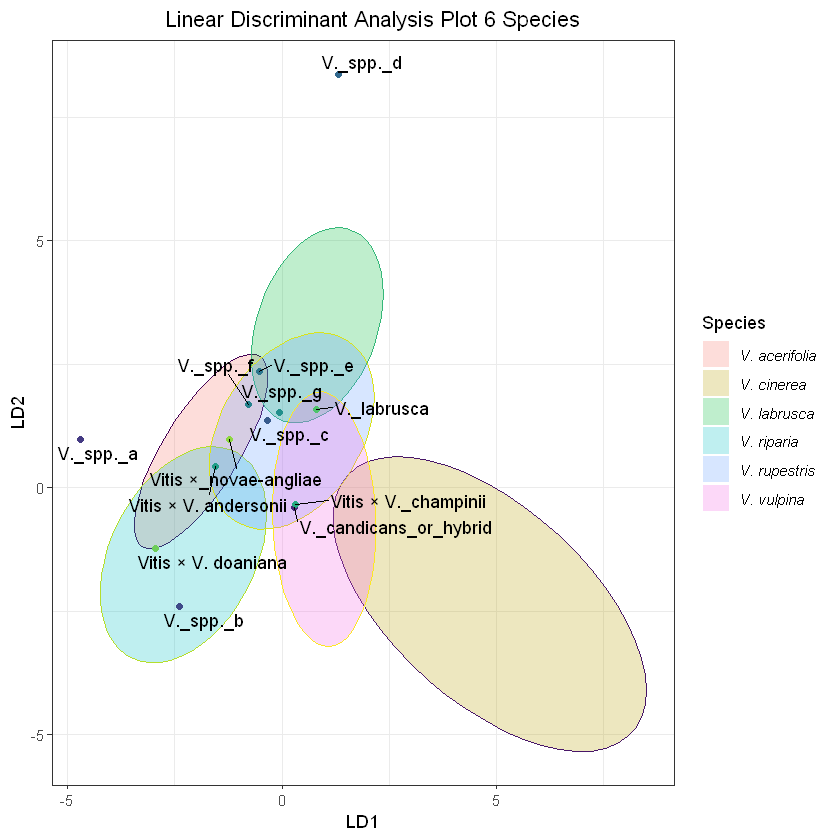

In [9]:
p <- ggplot(data = NULL) 
p <- p + stat_ellipse(data = viz.impute, aes(x = lda.LD1, y = lda.LD2, color = spec, fill = spec),geom = "polygon", alpha = .25) 
p <- p + geom_point(data = viz.hybrids, aes(x = lda.LD1, y = lda.LD2, color = spec))
p <- p + scale_color_viridis_d(aesthetics = "fill")
p <- p + scale_color_viridis_d(aesthetics = "color")
p <- p + theme_bw()
p <- p + xlab("LD1")
p <- p + ylab("LD2")
p <- p + labs(title = "Linear Discriminant Analysis Plot 6 Species")
p <- p + theme(plot.title = element_text(hjust = .55), legend.text = element_text(face = "italic"))
p <- p + scale_fill_discrete(name = "Species", labels = c("V. acerifolia","V. cinerea","V. labrusca","V. riparia","V. rupestris","V. vulpina"))
p <- p + guides(color = FALSE)
p <- p + geom_text_repel(aes(x = viz.hybrids$lda.LD1, y = viz.hybrids$lda.LD2), label = rownames(viz.hybrids), vjust = "inward",
                 hjust = "inward")
p
ggsave(filename = "LDA_Six.jpg", dpi = "retina")

In [10]:
#mice data
confusionMatrix( data=as.factor(predictions.mice$class), reference = as.factor(test.data.mice$spec_as_int), dnn = c("Prediction", "Reference"), prevalence = NULL, mode="everything")

Confusion Matrix and Statistics

          Reference
Prediction  1  3  4  6  7  8
         1  3  0  0  1  0  0
         3  0  5  0  0  0  0
         4  0  0  7  0  1  0
         6  0  0  0 11  1  0
         7  0  0  0  0  5  0
         8  0  1  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.8889          
                 95% CI : (0.7394, 0.9689)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 6.677e-12       
                                          
                  Kappa : 0.8584          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 3 Class: 4 Class: 6 Class: 7 Class: 8
Sensitivity           1.00000   0.8333   1.0000   0.9167   0.7143  1.00000
Specificity           0.96970   1.0000   0.9655   0.9583   1.0000  0.97143
Pos Pred Value        0.75000   1.0000   0.8750   0.9167   1.0000  0.50000
Neg Pred Value

In [11]:
#missMDA data
confusionMatrix( data=as.factor(predictions.impute$class), reference = as.factor(test.data.impute$spec_as_int), dnn = c("Prediction", "Reference"), prevalence = NULL, mode="everything")

Confusion Matrix and Statistics

          Reference
Prediction  1  3  4  6  7  8
         1  3  0  0  1  0  0
         3  0  5  0  0  0  0
         4  0  0  7  0  1  0
         6  0  0  0 11  1  0
         7  0  0  0  0  5  0
         8  0  1  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.8889          
                 95% CI : (0.7394, 0.9689)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 6.677e-12       
                                          
                  Kappa : 0.8584          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 3 Class: 4 Class: 6 Class: 7 Class: 8
Sensitivity           1.00000   0.8333   1.0000   0.9167   0.7143  1.00000
Specificity           0.96970   1.0000   0.9655   0.9583   1.0000  0.97143
Pos Pred Value        0.75000   1.0000   0.8750   0.9167   1.0000  0.50000
Neg Pred Value